<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-fundamentals/unit08-NLP/01-bag-of-words/02_self_attention_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Self-attention works from scratch

**Reference**

[Understanding and Coding the Self-Attention Mechanism of Large Language Models From Scratch](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html)


##Setup

In [ ]:
!pip install datasets
!pip install torch torchvision torchaudio
!pip install lightning
!pip install torchmetrics
!pip install mlxtend==0.21.0

In [ ]:
%%shell

wget https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit08-large-language-models/8.2-bag-of-words/local_utilities.py
wget https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit08-large-language-models/8.2-bag-of-words/local_dataset_utilities.py

In [ ]:
import os.path as op

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [3]:
import numpy as np
import pandas as pd
import torch

from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader

In [ ]:
!mkdir logs

## 1) Embedding Input Sentence

In [2]:
sentence = "Life is short, eat dessert first"

# create vocab
vocab = {w: i for i, w in enumerate(sorted(sentence.replace(",", "").split()))}
vocab

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}

In [4]:
# let's make integer-vector representation
sentence_vec = torch.tensor([vocab[w] for w in sentence.replace(",", "").split()])
sentence_vec

tensor([0, 4, 5, 2, 1, 3])

In [6]:
torch.manual_seed(123)

# let's embed this integer-vector representation
embedding = torch.nn.Embedding(6, 16)
embedded_sentence = embedding(sentence_vec).detach()

print(embedded_sentence.shape)
print(embedded_sentence)

torch.Size([6, 16])
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196, -0.3792,
          0.7671, -1.1925,  0.6984, -1.4097,  0.1794,  1.8951,  0.4954,  0.2692],
        [ 0.5146,  0.9938, -0.2587, -1.0826, -0.0444,  1.6236, -2.3229,  1.0878,
          0.6716,  0.6933, -0.9487, -0.0765, -0.1526,  0.1167,  0.4403, -1.4465],
        [ 0.2553, -0.5496,  1.0042,  0.8272, -0.3948,  0.4892, -0.2168, -1.7472,
         -1.6025, -1.0764,  0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [-1.3250,  0.1784, -2.1338,  1.0524, -0.3885, -0.9343, -0.4991, -1.0867,
          0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850],
        [-0.0770, -1.0205, -0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010,
          0.4965, -1.5723,  0.9666, -1.1481, -1.1589,  0.3255, -0.6315, -2.8400],
        [ 0.8768,  1.6221, -1.4779,  1.1331, -1.2203,  1.3139,  1.0533,  0.1388,
          2.2473, -0.8036, -0.2808,  0.7697, -0.6596, -0.7979,  0.1838,  0.2293]])


## 2)  Weight Matrices

35000

In [ ]:
len(cv.vocabulary_)

10000

In [ ]:
cv.vocabulary_

{'started': 8515,
 'watching': 9725,
 'series': 7957,
 'cable': 1320,
 'idea': 4488,
 'hate': 4191,
 'character': 1544,
 'hold': 4339,
 'beautifully': 892,
 'developed': 2574,
 'understand': 9375,
 'react': 7196,
 'frustration': 3737,
 'fear': 3439,
 'greed': 4020,
 'temptation': 8974,
 'way': 9736,
 'viewer': 9574,
 'experiencing': 3280,
 'christopher': 1656,
 'learning': 5199,
 'br': 1151,
 'abuse': 188,
 'physically': 6608,
 'emotionally': 3046,
 'just': 4963,
 'read': 7199,
 'newspaper': 6088,
 'women': 9880,
 'tolerate': 9134,
 'behavior': 915,
 'dream': 2831,
 'house': 4418,
 'endless': 3074,
 'supply': 8779,
 'expensive': 3276,
 'things': 9036,
 'sure': 8791,
 'loving': 5426,
 'faithful': 3371,
 'husband': 4465,
 'maybe': 5640,
 'watch': 9719,
 'doesn': 2754,
 'matter': 5630,
 'times': 9104,
 'episode': 3140,
 'missed': 5813,
 'episodes': 3141,
 'sequence': 7950,
 'season': 7869,
 'late': 5151,
 'night': 6101,
 'commercials': 1874,
 'language': 5133,
 'reruns': 7427,
 'movie': 5

In [ ]:
X_train = cv.transform(df_train["text"])
X_val = cv.transform(df_val["text"])
X_test = cv.transform(df_test["text"])

In [ ]:
X_train.shape

(35000, 10000)

In [ ]:
X_train[0]

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 74 stored elements in Compressed Sparse Row format>

In [ ]:
np.array(X_train[0].todense())[0]

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.bincount(np.array(X_train[0].todense())[0])

array([9926,   67,    5,    0,    1,    0,    1])

In [ ]:
X_train[0].todense().flatten()

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [ ]:
np.array(X_train.todense()).shape

(35000, 10000)

##3) DataLoader

In [ ]:
class TextDataset(Dataset):
  def __init__(self, X, y):
    self.features = torch.tensor(X, dtype=torch.float32)
    self.labels = torch.tensor(y, dtype=torch.int64)

  def __getitem__(self, index):
    x = self.features[index]
    y = self.labels[index]
    return x, y

  def __len__(self):
    return self.labels.shape[0]

In [ ]:
train_ds = TextDataset(X_train.todense(), df_train["label"].values)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
)

In [ ]:
val_ds = TextDataset(X_val.todense(), df_val["label"].values)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=True,
)

In [ ]:
test_ds = TextDataset(X_test.todense(), df_test["label"].values)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=True,
)

In [ ]:
for batch_idx, (features, class_labels) in enumerate(train_loader):
    break

In [ ]:
features.shape

torch.Size([32, 10000])

##4) Text Classifier

In [ ]:
class LogisticRegression(torch.nn.Module):

  def __init__(self, num_features, num_classes):
    super().__init__()
    self.linear = torch.nn.Linear(num_features, num_classes)

  def forward(self, x):
    logits = self.linear(x)
    return logits

In [ ]:
pytorch_model = LogisticRegression(num_features=10_000, num_classes=2)

In [ ]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [ ]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=30,
    accelerator="cpu",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

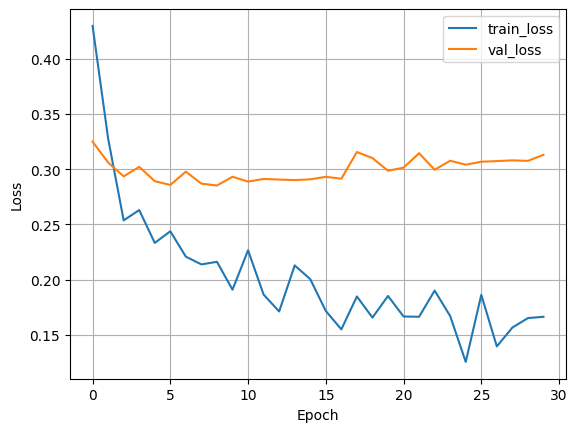

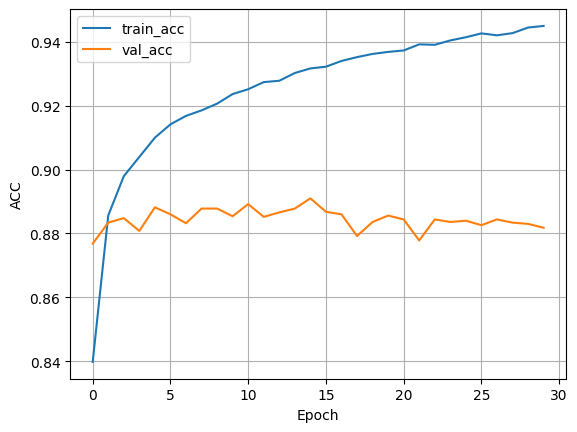

In [ ]:
plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

In [ ]:
trainer.test(model=lightning_model, dataloaders=test_loader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8812000155448914     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8812000155448914}]